# Computer Assignment 4 b) and 4 c) -- Group 2
* Ali Bemani
* Oscar Bautista Gonzalez
* Martin Hellkvist

For assignment 4b) we do the same preprocessing as in 4a).
The difference is that the workers now do not share their locally computed gradients, 
but instead share their local parameter values in a two-star topology ``(1,2,3,4)-5-6-(7,8,9,10)``.
We define a boolean connectivity matrix $A$ of shape ``(10,10)``.

We implement the local parameter values by defining a matrix ``W`` of shape ``(785,10)``.
In each iteration, the sequence of operations follows this scheme:
* for each worker ``i=1,...,10``:
    * get the degree ``d_i`` defined as the number of neighbors + 1
    * get all neighbors local parameters (corrupted by additive Gaussian noise (variance ``R``) with probability ``p``.
    * set ``w_bar`` to the average of all the received parameters together with the local parameter vector.
    * compute the gradient ``g`` w.r.t. ``w_bar``.
    * set the local parameter vetor to ``w_bar - alpha * g``, where ``alpha`` is the step size.
 
### Summary of results
We find similar results as in 4a), that higher ``R`` or ``p`` affects the level to which the cost or accuracy converges to.

### Answer to 4 c)
For the first setup from 4a), we would always protect the master worker from noisy connections, and then any other two. 
This because the master retreieves and sends information to all the other workers.

In the second setup, from 4b), we would choose to protect the workers 5 and 6, and any other third worker.
This because noisy connections from worker 5 (and equialently for worker 6) would in total generate 5 times more instances of noise than the transmissions from for example worker 1.

In [49]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
import sys
import matplotlib.pyplot as plt
import mnist
from PIL import Image

from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace


# the "resource" library is not available on windows. 
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource
    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")

Failed on importing 'resource' package, continuing wihtout it!


# Load data

In [50]:
train_data = mnist.train_images()
train_labels = mnist.train_labels()
test_data = mnist.test_images()
test_labels = mnist.test_labels()

(N_train, d0, d1) = train_data.shape
(N_test, _, _) = test_data.shape
decrease_bool = True

## Extract labels 1 and 0 for easier life

In [51]:
if decrease_bool:
    indexes_0 = (train_labels == 0)
    indexes_1 = (train_labels == 1)

    indexes_0_or_1 = indexes_0 + indexes_1

    test_labels = test_labels[0:5000]
    test_data = test_data[0:5000]

    indexes_0_test = (test_labels == 0)
    indexes_1_test = (test_labels == 1)

    indexes_0_or_1_test = indexes_0_test + indexes_1_test

    train_data = train_data[indexes_0_or_1,:,:]
    train_labels = train_labels[indexes_0_or_1].astype('float64')
    train_labels[train_labels==0] = -1

    test_data = test_data[indexes_0_or_1_test,:,:]
    test_labels = test_labels[indexes_0_or_1_test].astype('float64')
    test_labels[test_labels==0] = -1
    decrease_bool = False

-1.0


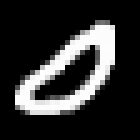

In [52]:
def print_image(idx, data, labels):
    scale= 5
    print(labels[idx])
    return Image.fromarray(np.repeat(np.repeat(data[idx,:,:], scale, axis=1), scale, axis=0))
N = train_data.shape[0]
idx = int(N*np.random.rand())
print_image(idx, train_data, train_labels)

(array([5923.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6742.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

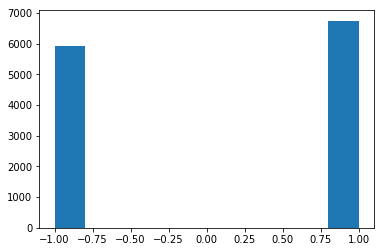

In [53]:
plt.hist(train_labels)

(array([460.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 571.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

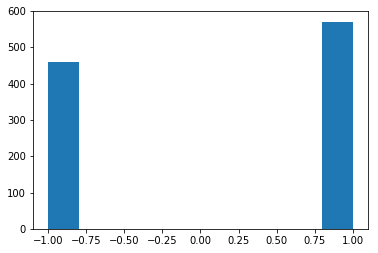

In [54]:
plt.hist(test_labels)

## Split into 10 random disjoint subsets

In [55]:
np.random.seed(0)
N_train = 600
N_data = test_data.shape[0]
N_workers = 10
indexes_ = np.random.choice(N_data, size=N_train, replace=False, p=None)
indexes_ = list(indexes_.reshape(10, -1))
X = [np.hstack((train_data[i].reshape(int(N_train/N_workers), -1)/255,np.ones((int(N_train/N_workers),1)))) for i in indexes_]
y = [train_labels[i].reshape(-1,1) for i in indexes_]

In [56]:
N_test = test_data.shape[0]
X_test = np.hstack((test_data.reshape(N_test, -1)/255,np.ones((N_test,1))))
y_test = test_labels.reshape(-1, 1)

# Define connectivity
To implement the two-star graph, we use a binary connectivity matrix, just to see which nodes are directly connected:

$$  A = 
\begin{bmatrix} 
1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 \\
1 & 1 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 \\
0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1
\end{bmatrix}  $$

In [57]:
A = np.identity(10, dtype='int8')
A[4,0:6] = 1
A[5,5:10] = 1
A[0:5,4] = 1
A[5:10,5] = 1
print(A)
A = A.astype('bool')


[[1 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 1]]


### Compute Grad

In [58]:
def compute_gradient(w, X, Y, lambda_):
    # returns a vector of shape w.shape, with gradients of w
    N = X.shape[0]
    L = hinge_loss(w, X, Y).flatten()
    YX_neg = -Y*X # (N, d)
    YX_neg[L == 0, :] = 0
    g = np.sum(YX_neg, axis=0, keepdims=1)
    g = g.T/N
    
    reg =  2*lambda_ * w
#     set_trace()

    return g + reg

### Compute hingeloss

In [59]:
def hinge_loss(w, X, Y):
#     set_trace()
    # returns the hinge loss for each datapoint in (X,Y) as a vector (N,1)
    (N, d) = X.shape
    assert w.shape == (d,1)
    assert Y.shape == (N,1)
    L = 1. - Y * (X @ w) # (N,1)
#     set_trace()
    L[L < 0] = 0.
    return L

### Cost

In [60]:
def cost(w, X, Y):
    return np.sum(hinge_loss(w,X,Y))

### Predict

In [61]:
def predict(w, X):
    return np.sign(X @ w)

### Accuracy

In [62]:
def accuracy(w, X, Y):
    N = X.shape[0]
    preds = predict(w, X)
    corrects = np.sum(preds == Y)
    return corrects/N

### Average over neighbors

In [63]:
def average_neigbors(W, A, noise_std, p_val):
    # return an average of the weights between the neighbors
    # the return is of shape W.shape
    (d,N_neighs) = W.shape
    for i in range(N_neighs):
        Ai = A[i,:]
        degree_i = np.sum(Ai)
#         set_trace()
        w_bar = np.sum(W[:, Ai], axis=1, keepdims=1) 
        for n in range(degree_i - 1):
            w_bar += np.random.normal(loc=0, scale=noise_std)*(np.random.rand() < p_val)
        assert w_bar.shape == (d, 1)
        W[:,[i]] = w_bar/degree_i
    return W

### Def solver

In [64]:
def solver(X, Y, X_test, Y_test, A, W, alpha, num_iters, lambda_, epsilon, optimizer = "GD",
           mini_batch = 100, mem=False, return_cost=False, verbose=True, seed=-1, p_val=0, R_val=0):
    
    N_workers = len(X)
    dw = W.shape[0]
    assert W.shape[1] == N_workers
    
    noise_std = R_val**0.5
    
    if seed != -1:
        np.random.seed(seed)
    
    cost_ = np.zeros(num_iters+1)
    cost_index = 1
    if return_cost:
        cost_[0] = cost(W[:,[cost_index]], X[cost_index], Y[cost_index])
    
    if (optimizer == "GD"):
        for i in range(num_iters):
            W = average_neigbors(W, A, noise_std, p_val)
            for worker_i in range(N_workers):
#                 set_trace()
                w = W[:,[worker_i]]
                g = compute_gradient(w, X[worker_i], Y[worker_i], lambda_)
                W[:,[worker_i]] = w - alpha * g
                
            if return_cost:
                cost_[i+1] = cost(W[:,[cost_index]], X[cost_index], Y[cost_index])
                
        if (verbose):
            print("GD: Number of iterations: ", num_iters, "/", num_iters)
            print("GD: final norm: ", np.linalg.norm(g))
            
    if return_cost:
        return cost_, w

# Run SVM solver on data

In [65]:
d = X[0].shape[1]
w = np.random.rand(d,10)
alpha = 0.03
num_iters = 500
lambda_ = 0.01
epsilon = 0
p_val = 0.5
r_val = .2
time1 = time.time()

cost_GD, w_out = solver(X, y, X_test, y_test, A, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
                 mem=False, return_cost=True, verbose=True, seed=1, p_val=p_val, R_val=r_val**2)
time2 = time.time()
print("Runtime GD num_iters=", time2-time1)

GD: Number of iterations:  500 / 500
GD: final norm:  0.5752282061573601
Runtime GD num_iters= 2.1163344383239746


final cost 7.183656957310211
final acc: 0.9709020368574199


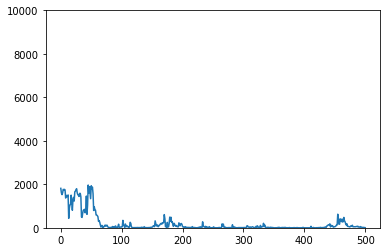

In [66]:
plt.plot(cost_GD)
print("final cost", cost_GD[-1])
plt.ylim(0,10000)

acc_final = accuracy(w_out, X_test, y_test)
print("final acc:", acc_final)

### grid over noise variance

In [67]:
d = X[0].shape[1]
w_in = np.random.rand(d,N_workers)
alpha = 0.03
num_iters = 200
lambda_ = .01
epsilon = 0

r_vector = [0.1, 0.2, .3, .4]
p_val = 0.5

cost_GD_R = [np.zeros(num_iters+1),np.zeros(num_iters+1),np.zeros(num_iters+1),np.zeros(num_iters+1)]
N_seeds = 100
for seed in range(N_seeds):
    cost_, w_out = solver(X, y, X_test, y_test, A, np.copy(w_in), alpha, num_iters, lambda_, epsilon, optimizer="GD",
                     mem=False, return_cost=True, verbose=False, seed=seed, p_val=p_val, R_val=r_vector[0]**2)
    cost_GD_R[0] += cost_/N_seeds
    cost_, w_out = solver(X, y, X_test, y_test, A, np.copy(w_in), alpha, num_iters, lambda_, epsilon, optimizer="GD",
                     mem=False, return_cost=True, verbose=False, seed=seed, p_val=p_val, R_val=r_vector[1]**2)
    cost_GD_R[1] += cost_/N_seeds

    cost_, w_out = solver(X, y, X_test, y_test, A, np.copy(w_in), alpha, num_iters, lambda_, epsilon, optimizer="GD",
                     mem=False, return_cost=True, verbose=False, seed=seed, p_val=p_val, R_val=r_vector[2]**2)
    cost_GD_R[2] += cost_/N_seeds

    cost_, w_out = solver(X, y, X_test, y_test, A, np.copy(w_in), alpha, num_iters, lambda_, epsilon, optimizer="GD",
                     mem=False, return_cost=True, verbose=False, seed=seed, p_val=p_val, R_val=r_vector[3]**2)
    cost_GD_R[3] += cost_/N_seeds
    
    print(".....", seed, ".....")
print("FIN")

..... 0 .....
..... 1 .....
..... 2 .....
..... 3 .....
..... 4 .....
..... 5 .....
..... 6 .....
..... 7 .....
..... 8 .....
..... 9 .....
..... 10 .....
..... 11 .....
..... 12 .....
..... 13 .....
..... 14 .....
..... 15 .....
..... 16 .....
..... 17 .....
..... 18 .....
..... 19 .....
..... 20 .....
..... 21 .....
..... 22 .....
..... 23 .....
..... 24 .....
..... 25 .....
..... 26 .....
..... 27 .....
..... 28 .....
..... 29 .....
..... 30 .....
..... 31 .....
..... 32 .....
..... 33 .....
..... 34 .....
..... 35 .....
..... 36 .....
..... 37 .....
..... 38 .....
..... 39 .....
..... 40 .....
..... 41 .....
..... 42 .....
..... 43 .....
..... 44 .....
..... 45 .....
..... 46 .....
..... 47 .....
..... 48 .....
..... 49 .....
..... 50 .....
..... 51 .....
..... 52 .....
..... 53 .....
..... 54 .....
..... 55 .....
..... 56 .....
..... 57 .....
..... 58 .....
..... 59 .....
..... 60 .....
..... 61 .....
..... 62 .....
..... 63 .....
..... 64 .....
..... 65 .....
..... 66 .....
.....

### Grid over p_val

In [68]:
d = X[0].shape[1]
w_in = np.random.rand(d,N_workers)
alpha = 0.03
num_iters = 200
lambda_ = 0.01
epsilon = 0

r_val = .1
p_vector = [0.1, 0.25, 0.5, 1]

cost_GD_p = [np.zeros(num_iters+1),np.zeros(num_iters+1),np.zeros(num_iters+1),np.zeros(num_iters+1)]
N_seeds = 100
for seed in range(N_seeds):
    cost_, w_out = solver(X, y, X_test, y_test, A, np.copy(w_in), alpha, num_iters, lambda_, epsilon, optimizer="GD",
                     mem=False, return_cost=True, verbose=False, seed=seed, p_val=p_vector[0], R_val=r_val**2)
    cost_GD_p[0] += cost_/N_seeds
    cost_, w_out = solver(X, y, X_test, y_test, A, np.copy(w_in), alpha, num_iters, lambda_, epsilon, optimizer="GD",
                     mem=False, return_cost=True, verbose=False, seed=seed, p_val=p_vector[1], R_val=r_val**2)
    cost_GD_p[1] += cost_/N_seeds

    cost_, w_out = solver(X, y, X_test, y_test, A, np.copy(w_in), alpha, num_iters, lambda_, epsilon, optimizer="GD",
                     mem=False, return_cost=True, verbose=False, seed=seed, p_val=p_vector[2], R_val=r_val**2)
    cost_GD_p[2] += cost_/N_seeds

    cost_, w_out = solver(X, y, X_test, y_test, A, np.copy(w_in), alpha, num_iters, lambda_, epsilon, optimizer="GD",
                     mem=False, return_cost=True, verbose=False, seed=seed, p_val=p_vector[3], R_val=r_val**2)
    cost_GD_p[3] += cost_/N_seeds
    
    print(".....", seed, ".....")
print("FIN")

..... 0 .....
..... 1 .....
..... 2 .....
..... 3 .....
..... 4 .....
..... 5 .....
..... 6 .....
..... 7 .....
..... 8 .....
..... 9 .....
..... 10 .....
..... 11 .....
..... 12 .....
..... 13 .....
..... 14 .....
..... 15 .....
..... 16 .....
..... 17 .....
..... 18 .....
..... 19 .....
..... 20 .....
..... 21 .....
..... 22 .....
..... 23 .....
..... 24 .....
..... 25 .....
..... 26 .....
..... 27 .....
..... 28 .....
..... 29 .....
..... 30 .....
..... 31 .....
..... 32 .....
..... 33 .....
..... 34 .....
..... 35 .....
..... 36 .....
..... 37 .....
..... 38 .....
..... 39 .....
..... 40 .....
..... 41 .....
..... 42 .....
..... 43 .....
..... 44 .....
..... 45 .....
..... 46 .....
..... 47 .....
..... 48 .....
..... 49 .....
..... 50 .....
..... 51 .....
..... 52 .....
..... 53 .....
..... 54 .....
..... 55 .....
..... 56 .....
..... 57 .....
..... 58 .....
..... 59 .....
..... 60 .....
..... 61 .....
..... 62 .....
..... 63 .....
..... 64 .....
..... 65 .....
..... 66 .....
.....

### PLOT

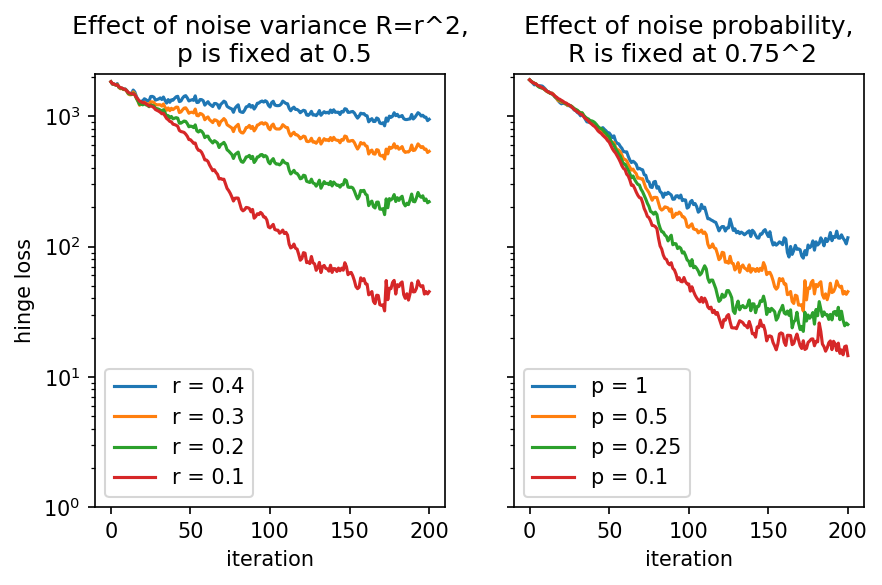

In [69]:
dpi = 150
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, dpi=dpi)
for i in reversed(range(4)):
    ax2.plot(cost_GD_p[i], label=("p = " + str(p_vector[i])))
ax2.legend(loc='best')
ax2.set_ylim(1,100)
# ax2.set_xlim(0,500)
ax2.set_yscale('log')
ax2.set_title("Effect of noise probability,\n R is fixed at 0.75^2")
ax2.set_xlabel("iteration")

# plt.subplot(2,2,1,dpi=dpi)
for i in reversed(range(4)):
    ax1.plot(cost_GD_R[i], label=("r = " + str(r_vector[i])))
ax1.legend(loc='best')
ax1.set_ylim(1,2100)
# ax1.set_xlim(0,500)
ax1.set_yscale('log')
ax1.set_title("Effect of noise variance R=r^2,\n p is fixed at 0.5")
ax1.set_ylabel("hinge loss")
ax1.set_xlabel("iteration")
plt.tight_layout()